In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize([0.3337, 0.3064, 0.3171], [0.2672, 0.2564, 0.2629])
])

# Load dataset
# original_dataset_dir = '/home/iai/Desktop/bsh/active_learning/data/mvtec2'
# classes_list = os.listdir(original_dataset_dir)

train_dataset = ImageFolder(root='/home/user/Desktop/bsh/mvtec_data_multi/train/toothbrush', transform=transform)
test_dataset = ImageFolder(root='/home/user/Desktop/bsh/mvtec_data_multi/test/toothbrush', transform=transform)

print(len(train_dataset))
print(len(test_dataset))

# print(len(classes_list))

81
21


In [3]:
#Define data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [4]:
# Define loss function and optimizer

EPOCHS = 200

criterion = nn.CrossEntropyLoss()

train_loss_list = []

def train(model, train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0.0
    for _,(image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    #train_loss_list.append(train_loss)
    
    return train_loss

In [5]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc

test_acc_list = []
test_loss_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []
test_fpr_list = []
test_tpr_list = []

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    
    with torch.no_grad():
      n_samples = 0
      y_true = []
      y_pred = []
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          output = model(images)
          test_loss += criterion(output, labels).item()
          _, predicted = torch.max(output,1)
          n_samples += labels.size(0)
          test_accuracy += (predicted == labels).sum().item()
          y_true.extend(labels.tolist())
          y_pred.extend(predicted.tolist())        
      test_accuracy /= n_samples
      test_loss /= len(test_loader)
      # test_acc_list.append(test_accuracy/n_samples * 100.)
      # test_loss_list.append(len(test_loader) * 100.)

      precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro', zero_division=1)
      cm = confusion_matrix(y_true, y_pred)
      print("Confusion Matrix")
      print(cm)
      # TN FP
      # FN TP
      test_precision_list.append(precision)
      test_recall_list.append(recall)
      test_f1_list.append(f1)
      print(f"Test Precision: {precision.item():.4f}, Test Recall: {recall.item():.4f}, Test F1 Score: {f1.item():.4f}")

      # Compute macro F1 score
      macro_f1 = np.mean(test_f1_list)
      print(f"Macro F1 score: {macro_f1:.4f}")

      # Compute AUC score and ROC curve
      fpr, tpr, thresholds = roc_curve(y_true, y_pred)
      roc_auc = auc(fpr, tpr)
      auc_score = roc_auc_score(y_true, y_pred)
      # test_auc_list.append(auc_score)
      test_fpr_list.append(fpr)
      test_tpr_list.append(tpr)
      # print(f"AUC Score: {auc_score:.4f}")

    return test_loss, test_accuracy, auc_score, f1, macro_f1

In [6]:
# Pretrained : 미리 학습된 resnet18모델을 불러온 후 이미지 데이터에 맞게 Fine Tuning

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
# Because num of class is 2
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)  #active learning
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4) #pt4al


In [7]:
for EPOCH in range(EPOCHS):
    train(model, train_loader,optimizer, log_interval = 5)
    train_loss = train(model, train_loader,optimizer, log_interval = 5)
    train_loss_list.append(train_loss)
    print("[EPOCH:{}],\tTrain Loss: {:.4f},".format(EPOCH+1, train_loss))

    # 모델 저장 (현재 손실이 이전 최상의 손실보다 낮을 때)
    if EPOCH == 0 or train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), 'best_binary_ideal_model.pth')  # 모델의 파라미터 저장


[EPOCH:1],	Train Loss: 0.9901,
[EPOCH:2],	Train Loss: 0.7092,
[EPOCH:3],	Train Loss: 0.6334,
[EPOCH:4],	Train Loss: 0.5795,
[EPOCH:5],	Train Loss: 0.6661,
[EPOCH:6],	Train Loss: 0.5798,
[EPOCH:7],	Train Loss: 0.6074,
[EPOCH:8],	Train Loss: 0.5187,
[EPOCH:9],	Train Loss: 0.4326,
[EPOCH:10],	Train Loss: 0.5159,
[EPOCH:11],	Train Loss: 0.2889,
[EPOCH:12],	Train Loss: 0.9743,
[EPOCH:13],	Train Loss: 0.1778,
[EPOCH:14],	Train Loss: 0.0902,
[EPOCH:15],	Train Loss: 0.0820,
[EPOCH:16],	Train Loss: 0.1213,
[EPOCH:17],	Train Loss: 0.4619,
[EPOCH:18],	Train Loss: 0.0604,
[EPOCH:19],	Train Loss: 0.0622,
[EPOCH:20],	Train Loss: 0.0330,
[EPOCH:21],	Train Loss: 0.0184,
[EPOCH:22],	Train Loss: 0.0145,
[EPOCH:23],	Train Loss: 0.0120,
[EPOCH:24],	Train Loss: 0.0103,
[EPOCH:25],	Train Loss: 0.0090,
[EPOCH:26],	Train Loss: 0.0080,
[EPOCH:27],	Train Loss: 0.0072,
[EPOCH:28],	Train Loss: 0.0065,
[EPOCH:29],	Train Loss: 0.0058,
[EPOCH:30],	Train Loss: 0.0053,
[EPOCH:31],	Train Loss: 0.0049,
[EPOCH:32],	Train

In [8]:
# 모델을 불러올 준비
best_model = model
best_model.load_state_dict(torch.load('best_binary_ideal_model.pth'))  # 저장된 모델 파라미터를 불러옴
best_model.to(device)  # 디바이스 설정
best_model.eval()  # 모델을 평가 모드로 설정

test_loss, test_accuracy, auc_score, f1, macro_f1 = evaluate(model, test_loader)
test_acc_list.append(test_accuracy)
test_loss_list.append(test_loss)
test_auc_list.append(auc_score)
test_f1_list.append(f1)
print("-------------------------------------------------------------------")
print(f"Test F1 Score: {f1}")
print("[EPOCH:{}],\tTest Loss: {:.4f}, \tTest Accuracy:{:.4f},\tAUC_score: {:.4f}".format(EPOCHS, test_loss, test_accuracy, auc_score))
print("-------------------------------------------------------------------")


Confusion Matrix
[[ 1  5]
 [ 3 12]]
Test Precision: 0.4779, Test Recall: 0.4833, Test F1 Score: 0.4750
Macro F1 score: 0.4750
-------------------------------------------------------------------
Test F1 Score: 0.4750000000000001
[EPOCH:200],	Test Loss: 1.7852, 	Test Accuracy:0.6190,	AUC_score: 0.4833
-------------------------------------------------------------------


In [9]:
print("[Test accuracy :{}]".format(test_acc_list))
print("[Test loss :{}]".format(test_loss_list))

print(train_loss_list)
print(test_f1_list)


[Test accuracy :[0.6190476190476191]]
[Test loss :[1.785228210190932]]
[0.9900581174426608, 0.7092356118890975, 0.6333826002147462, 0.5795454565021727, 0.6661024540662766, 0.5798011471827825, 0.6074290871620178, 0.5186816106239954, 0.4326227588786019, 0.5159368163181676, 0.28894805452889866, 0.9743388758765327, 0.17782034973303476, 0.09015354928043154, 0.08199003959695499, 0.12133568877147304, 0.4619342800643709, 0.060374023806717664, 0.062169119198289186, 0.032993475906550884, 0.018366732945044834, 0.014548270187030235, 0.012044798013650708, 0.010336067837973436, 0.009047228273832135, 0.008007445708952017, 0.007158191693532798, 0.006451462783540289, 0.005845806147489283, 0.005328588161824478, 0.004883188133438428, 0.004509219550527632, 0.004168619906219344, 0.003865557024255395, 0.0035822857624023324, 0.0033364079685674775, 0.0031262823225309453, 0.0029495409689843655, 0.0027931674590541255, 0.0026366948538149395, 0.002466557967838728, 0.0023240021772734406, 0.0022014560074441964, 0.0

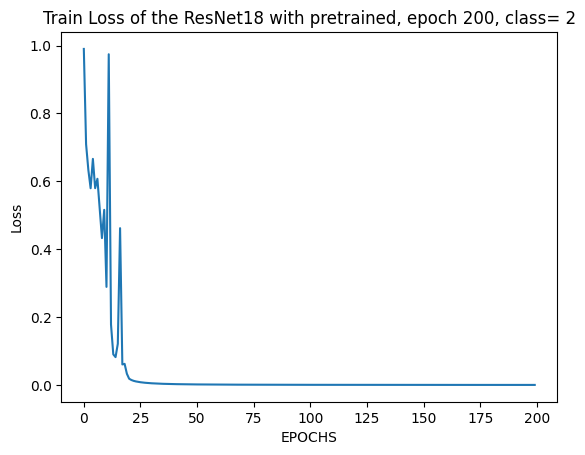

In [10]:
plt.plot(train_loss_list)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Train Loss of the ResNet18 with pretrained, epoch {}, class= 2'.format(EPOCHS))
plt.legend
plt.show()

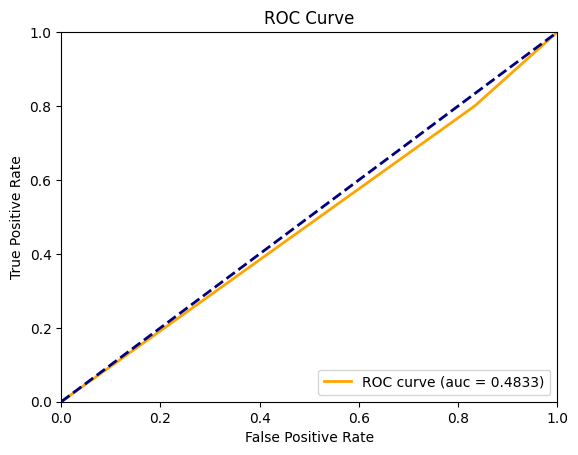

In [11]:
plt.plot(test_fpr_list[-1], test_tpr_list[-1], color='orange', lw=2, label='ROC curve (auc = %0.4f)' % auc(test_fpr_list[-1], test_tpr_list[-1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()